In [2]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from scipy.ndimage.interpolation import shift
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import newton
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import plotly
plotly.offline.init_notebook_mode()
import plotly.plotly as py
from plotly.offline import iplot,plot
import plotly.graph_objs as go
import time
import re
import math
import seaborn as sns

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import heapq
%matplotlib inline


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
start_time = time.time()
engine = create_engine('sqlite+pysqlite:///../../data/SQL/10C/85_8.db')
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
end_time = time.time()
print end_time-start_time

engine = create_engine('sqlite+pysqlite:///../../data/SQL/10C/ProtoMap.db')
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
print ProtoMapdf.head()

169.18030405
   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4


In [4]:
start_time = time.time()
ADCdf.columns = [np.uint16(_[1:]) if re.match('t\d+',_) is not None else _ for _ in ADCdf.columns ]
ADCdf['max'] = ADCdf.iloc[:,3+50:-50].max(axis=1)
mask= (ADCdf.iloc[:,3:-1]>20) & (ADCdf.iloc[:,3:-1].gt(ADCdf['max']*0.2,axis=0))
ADCdf.iloc[:,3:-1] = ADCdf.iloc[:,3:-1][mask].fillna(0)
end_time = time.time()
print end_time-start_time

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:1612: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:1592: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:2393: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



14.7965970039


In [5]:
start_time = time.time()
n1 = [_ for _ in ADCdf.columns if type(_) is np.uint16]
n2 = [_ for _ in ADCdf.columns if type(_) is not np.uint16]
t2 = pd.melt(ADCdf.iloc[:],id_vars=n2,value_vars=n1).drop(['ID'],axis=1)
t2.columns = ['EventID','PadNum','max','time','charge']
t3 = pd.merge(t2[t2['charge']>20],ProtoMapdf,on='PadNum')[['EventID','PadNum','time','PadX','PadY','charge']]
print time.time() - start_time

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:2549: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:1211: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



35.5777139664


In [18]:
EID=233

tmp = t3[(t3['EventID']==EID)&(t3['charge']>3)]
#print tmp['PadNum'].unique()

#tmp['PadPos'] = (tmp['PadNum']%63>9)*(tmp['PadNum']%63-9) +tmp['PadNum']%63
p = (tmp['PadNum']-1)%63+1
#print "shit:",np.sum((1+(p>9))==0)

tmp['PadPos'] = ((p-9)*(p>9)+p)*(tmp['PadNum']!=0)

weights = np.abs(np.arange(1,301,1)-150.5)
weights = np.repeat([weights], 550, axis=0).T*100

Q1 = tmp[(tmp['PadX']>0)&(tmp['PadY']>0)]
Q2 = tmp[(tmp['PadX']<0)&(tmp['PadY']>0)]
Q3 = tmp[(tmp['PadX']<0)&(tmp['PadY']<0)]
Q4 = tmp[(tmp['PadX']>0)&(tmp['PadY']<0)]


image1 = np.zeros([300,600])

image1[(-Q1['PadPos'].values+150).astype(np.int), Q1['time'].values.astype(np.int)] =255
image1[(Q3['PadPos'].values+150).astype(np.int), Q3['time'].values.astype(np.int)] =255

image2 = np.zeros([300,600])

image2[(-Q2['PadPos'].values+150).astype(np.int), Q2['time'].values.astype(np.int)] =255
image2[(Q4['PadPos'].values+150).astype(np.int), Q4['time'].values.astype(np.int)] =255



if np.sum(image1-image2)>0:
    image = image1 
else:
    image = image2


########################

gray = cv2.GaussianBlur(image, (3, 3), 0)
print np.any(gray*255<0)
print gray.shape,np.max(gray)
ret,im = cv2.threshold(gray.astype(np.uint8), 10, 255, cv2.THRESH_BINARY)

False
(300, 600) 255.0


/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [19]:
def Process(EID):
    
    tmp = t3[(t3['EventID']==EID)&(t3['charge']>3)]
    #print tmp['PadNum'].unique()

    #tmp['PadPos'] = (tmp['PadNum']%63>9)*(tmp['PadNum']%63-9) +tmp['PadNum']%63
    p = (tmp['PadNum']-1)%63+1
    #print "shit:",np.sum((1+(p>9))==0)
    
    tmp['PadPos'] = ((p-9)*(p>9)+p)*(tmp['PadNum']!=0)
    
    weights = np.abs(np.arange(1,301,1)-150.5)
    weights = np.repeat([weights], 550, axis=0).T*100

    Q1 = tmp[(tmp['PadX']>0)&(tmp['PadY']>0)]
    Q2 = tmp[(tmp['PadX']<0)&(tmp['PadY']>0)]
    Q3 = tmp[(tmp['PadX']<0)&(tmp['PadY']<0)]
    Q4 = tmp[(tmp['PadX']>0)&(tmp['PadY']<0)]


    image1 = np.zeros([300,600])

    image1[(-Q1['PadPos'].values+150).astype(np.int), Q1['time'].values.astype(np.int)] =255
    image1[(Q3['PadPos'].values+150).astype(np.int), Q3['time'].values.astype(np.int)] =255

    image2 = np.zeros([300,600])

    image2[(-Q2['PadPos'].values+150).astype(np.int), Q2['time'].values.astype(np.int)] =255
    image2[(Q4['PadPos'].values+150).astype(np.int), Q4['time'].values.astype(np.int)] =255



    if np.sum(image1-image2)>0:
        image = image1 
    else:
        image = image2


    ########################

    gray = cv2.GaussianBlur(image, (3, 3), 0)


    ret,im = cv2.threshold(gray.astype(np.uint8), 10, 255, cv2.THRESH_BINARY)

    
    
    thresh = im.astype(np.uint8)
    for _ in range(10):
        thresh = cv2.erode(thresh, None, iterations=1)
        thresh = cv2.dilate(thresh, None, iterations=1)


    m1, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #hull = cv2.convexHull(cnt)
    plt.figure(figsize=(16, 12))
    sns.heatmap(thresh[::-1])

    #plt.imshow(thresh)

    
    
    def Distance(c1,c2):

        c1,c2 = c1[:,0,:],c2[:,0,:]

        m1 = np.repeat([c1],c2.shape[0],axis=0)
        m2 = np.repeat([c2],c1.shape[0],axis=0)
        t2 = np.transpose(m2,axes=(1,0,2))
        diff = np.sqrt(np.sum(np.power(m1-t2,2),axis=2))

        return np.min(diff)

    gpc = []
    gpa = []

    cont = [(a,cv2.contourArea(a)) for a in contours]

    #cont =  [(c,a) for c,a in cont if a>100]

    for cnt,ca in cont:

        flag = True

        for g in gpc:
            for c in g[:]:

                if Distance(cnt,c) <20:
                    g.append(cnt)
                    flag = False
                    gpa[-1] += ca
                else:
                    break

        if flag:
            gpc.append([cnt])
            gpa.append(ca)


    gpc = [np.concatenate(g,axis=0) for g in gpc]


    cnt = gpc[np.argmax(gpa)]
    hull = cv2.convexHull(cnt)
    #############################
    def area(*i):
        a,b,c= hull[i,0]
        return np.abs(np.cross(b-c,c-a))

    A = 0;B = 1; C = 2; n=hull.shape[0]
    bA= A; bB= B; bC= C #The "best" triple of points
    while True: #loop A
        while True: #loop B
            while area(A, B, C) <= area(A, B, (C+1)%n): #loop C
                C = (C+1)%n
            if area(A, B, C) <= area(A, (B+1)%n, C): 
                B = (B+1)%n
                continue
            else:
                break

        if area(A, B, C) > area(bA, bB, bC):
            bA = A; bB = B; bC = C

        A = (A+1)%n
        if A==B: B = (B+1)%n
        if B==C: C = (C+1)%n
        if A==0: break

    idx = sorted(range(len(gpc)),key=lambda x:gpa[x])
    gpc,gpa = zip(*[(gpc[i],gpa[i]) for i in idx])
    


    for c in gpc[:]:
        plt.scatter(*zip(*c[:,0]))
    
    
    cnt = gpc[np.argmax(gpa)]
    hull = cv2.convexHull(cnt)

    #plt.figure()
    #plt.imshow(image, cmap='gray')
    #plt.scatter(cnt.T[0],cnt.T[1],s=1)
    #plt.scatter(hull.T[0],hull.T[1],s=2)
    #plt.figure(figsize=(16, 12))

    #sns.heatmap(image2)
    
    
    
    #pltplot()
    #plt.imshow(image2)
    #plt.plot(*hull[[bA,bB,bC,bA],0].T,c='r')        

    #plt.figure(figsize=(16, 12))
    #x,y = np.where(image2>2)
    #plt.scatter(x,y,s=1)
    #plt.xlim([148,152])
    
    print Q2[Q2['PadPos']==0]

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Empty DataFrame
Columns: [EventID, PadNum, time, PadX, PadY, charge, PadPos]
Index: []


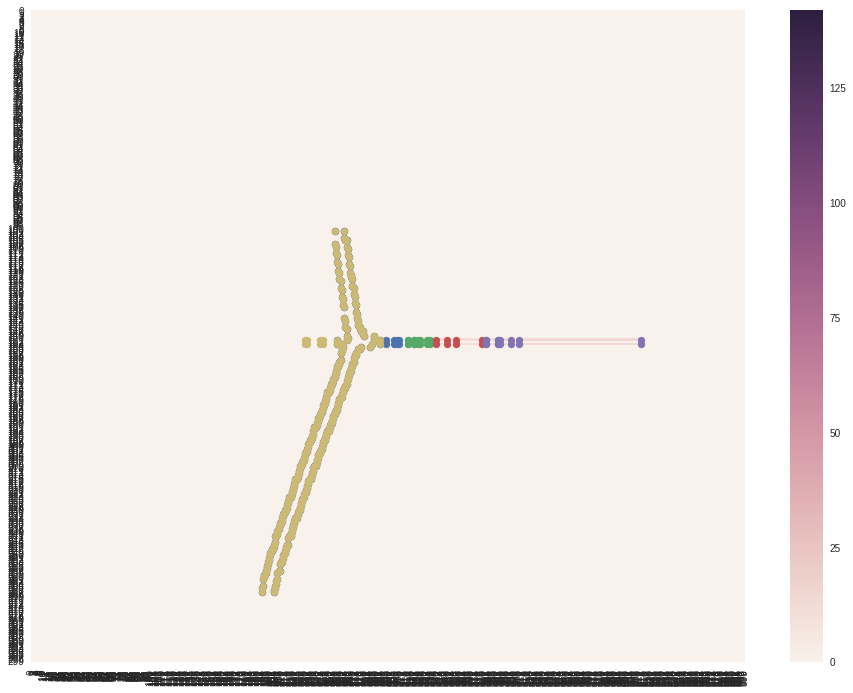

In [20]:
plt.figure(figsize=(20,20))
Process(233)
#pic = Process(233)
#sns.heatmap(pic[::-1])

In [10]:
 cv2.THRESH_BINARY

0

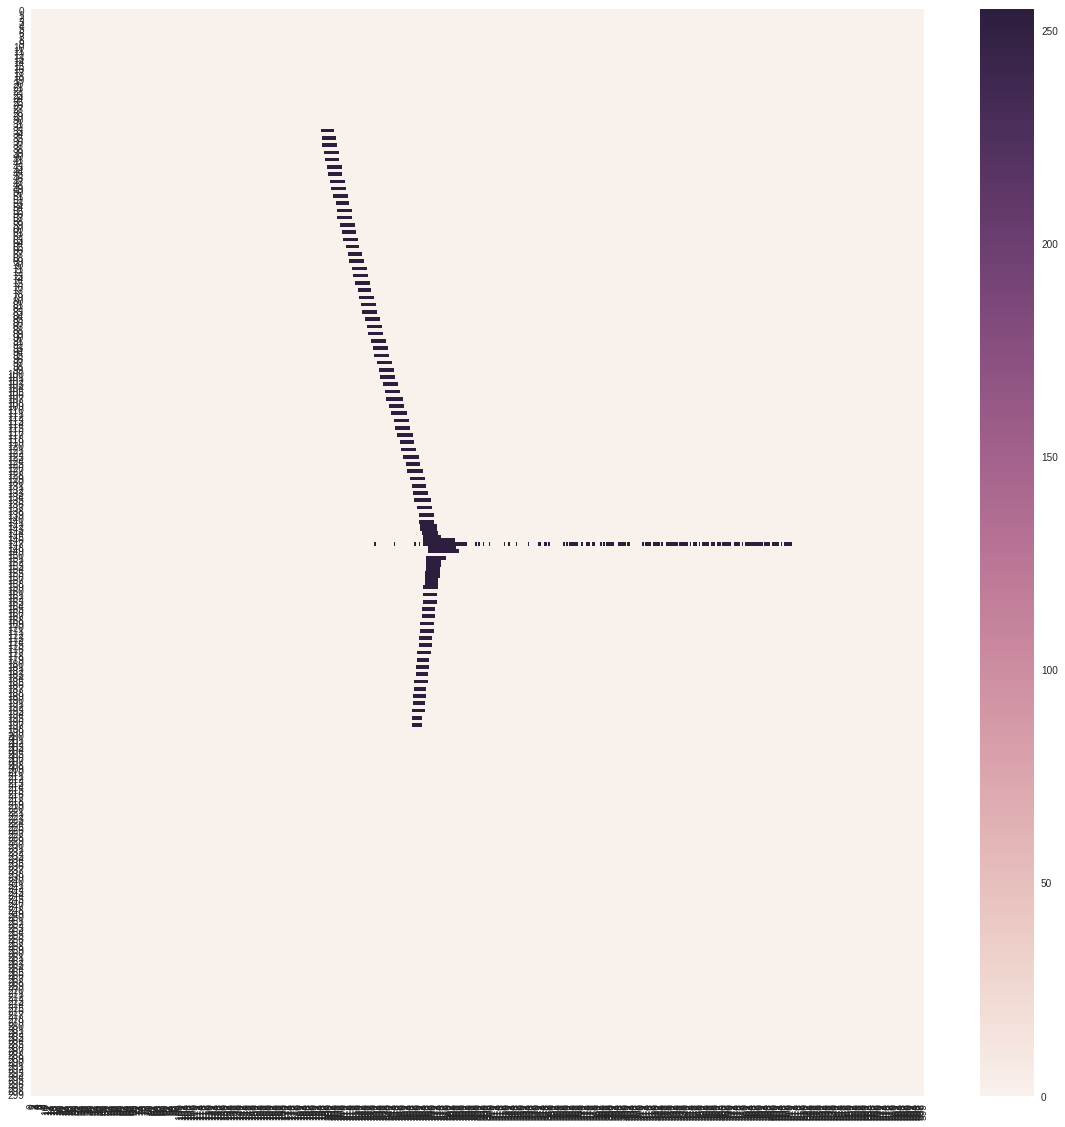

In [39]:
plt.figure(figsize=(20,20))
sns.heatmap(image2)

In [55]:
EID = 233
tmp = t3[(t3['EventID']==EID)&(t3['charge']>3)]
p = (tmp['PadNum']-1)%63+1

tmp['PadPos'] = ((p-9)*(p>9)+p)*(tmp['PadNum']!=0)

Q1 = tmp[(tmp['PadX']>0)&(tmp['PadY']>0)]
Q2 = tmp[(tmp['PadX']<0)&(tmp['PadY']>0)]
Q3 = tmp[(tmp['PadX']<0)&(tmp['PadY']<0)]
Q4 = tmp[(tmp['PadX']>0)&(tmp['PadY']<0)]


image1 = np.zeros([300,600])
image1[(Q1['PadPos'].values+150).astype(np.int), Q1['time'].values.astype(np.int)] =255

image2 = np.zeros([300,600])
image2[(Q3['PadPos'].values+150).astype(np.int), Q3['time'].values.astype(np.int)] =255

image3 = np.zeros([300,600])
image3[(Q2['PadPos'].values+150).astype(np.int), Q2['time'].values.astype(np.int)] =255

image4 = np.zeros([300,600])
image4[(Q4['PadPos'].values+150).astype(np.int), Q4['time'].values.astype(np.int)] =255

/afs/crc.nd.edu/user/j/jlai1/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



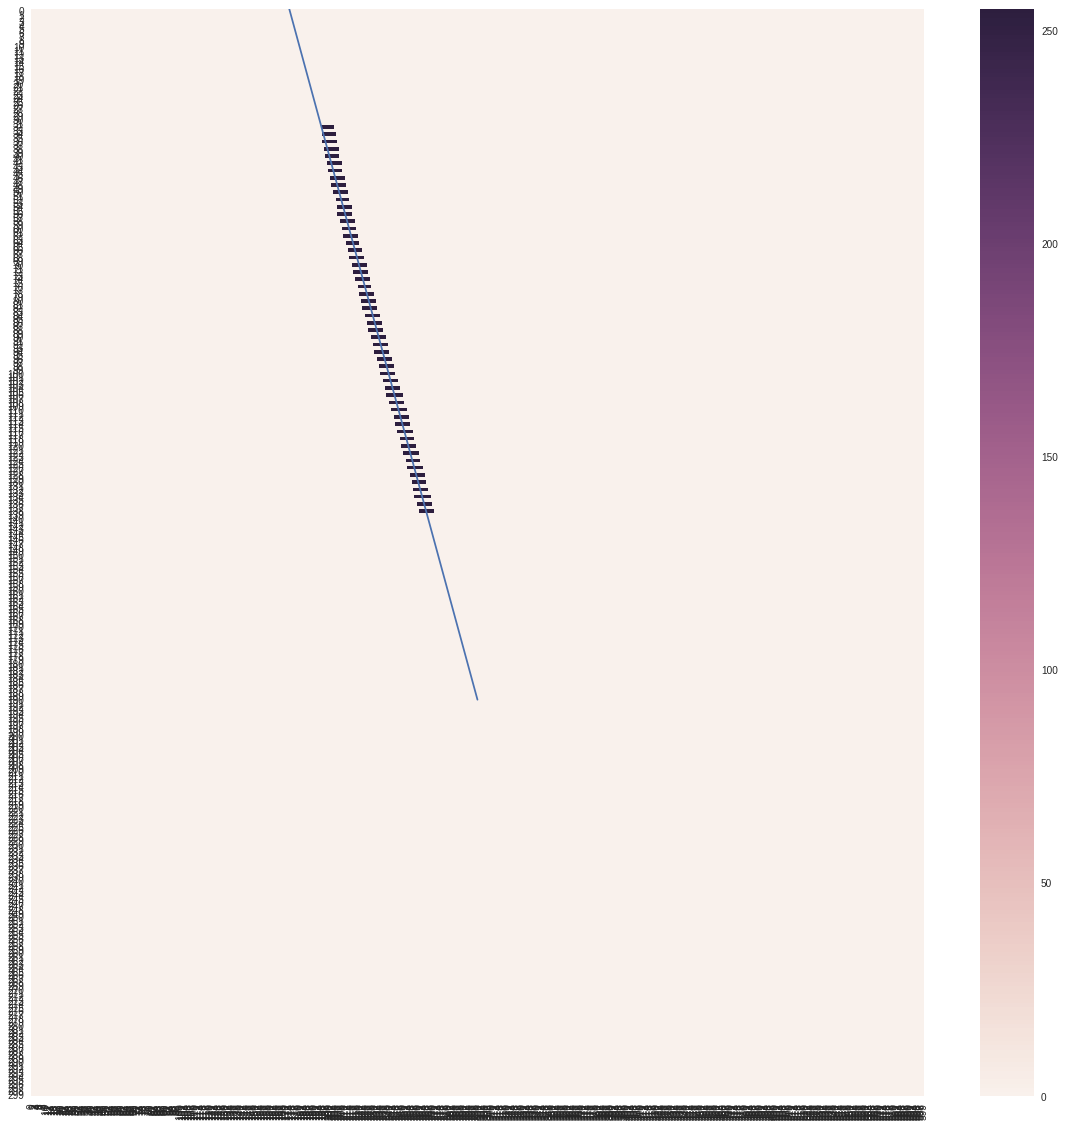

In [76]:
image = np.zeros([300,600])
Q = Q2[Q2['PadPos'].abs()>10]

k,b= np.polyfit(Q['time'].astype(np.float),Q['PadPos'].values+150,1)

image[(Q['PadPos'].values+150).astype(np.int), Q['time'].values.astype(np.int)] =255
#plt.plot()

plt.figure(figsize=(20,20))
sns.heatmap(image[::-1])
plt.plot([0,300],[561.4283658,-1.50696312*300+ 561.4283658 ])




In [146]:
image1 = np.zeros([300,600])
image1[(-Q2['PadPos'].values+150).astype(np.int), Q2['time'].values.astype(np.int)] =255

image1[(Q4['PadPos'].values+150).astype(np.int), Q4['time'].values.astype(np.int)] =255

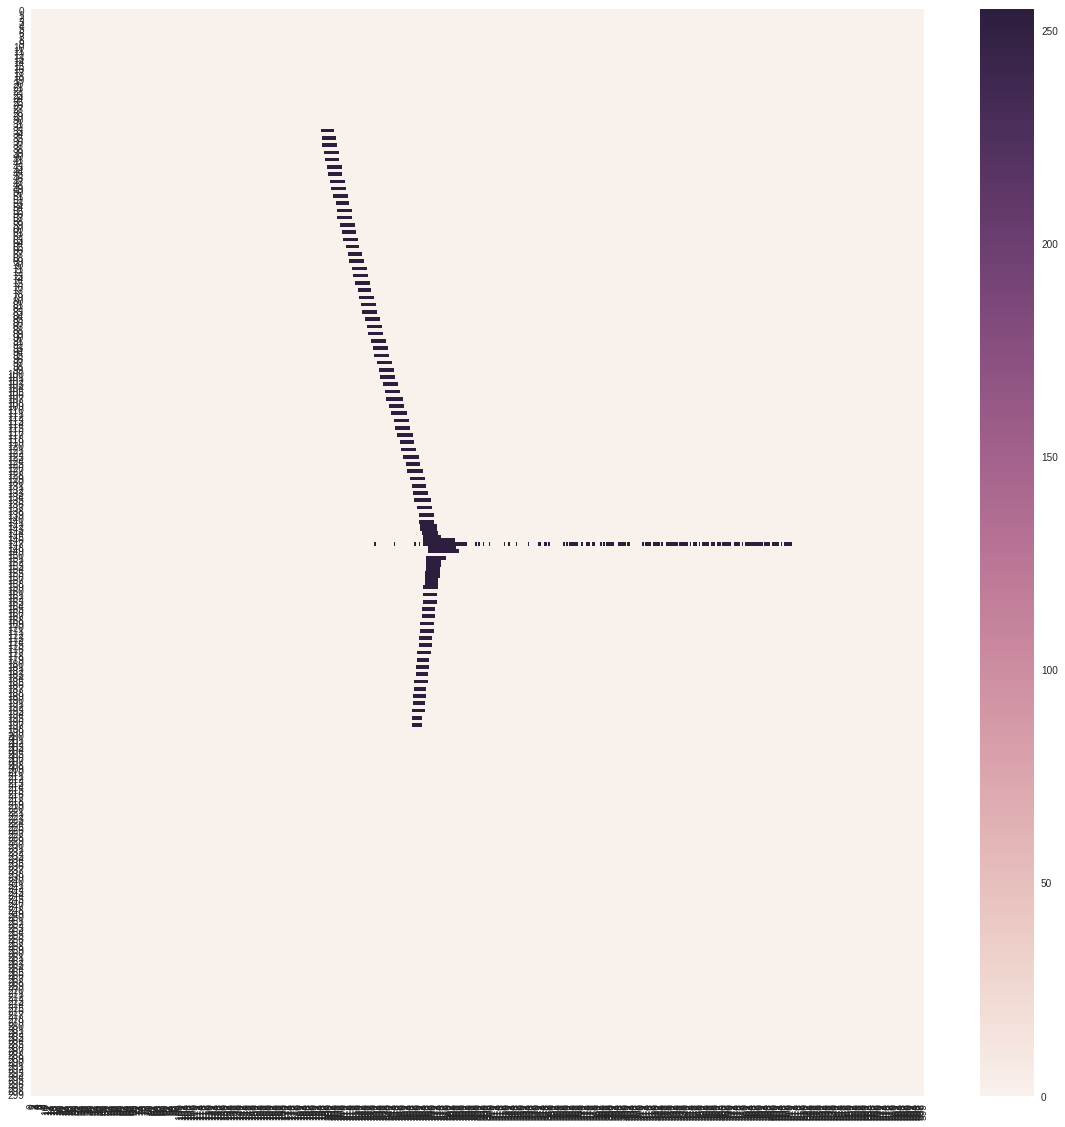

In [101]:
plt.figure(figsize=(20,20))

x0 = (150.0-b)/k
#print x0
#image1[:,:int(x0)]=0

sns.heatmap(image1)


In [108]:
x0 = (150.0-b)/k

image1[:,:int(x0)+20] = 0

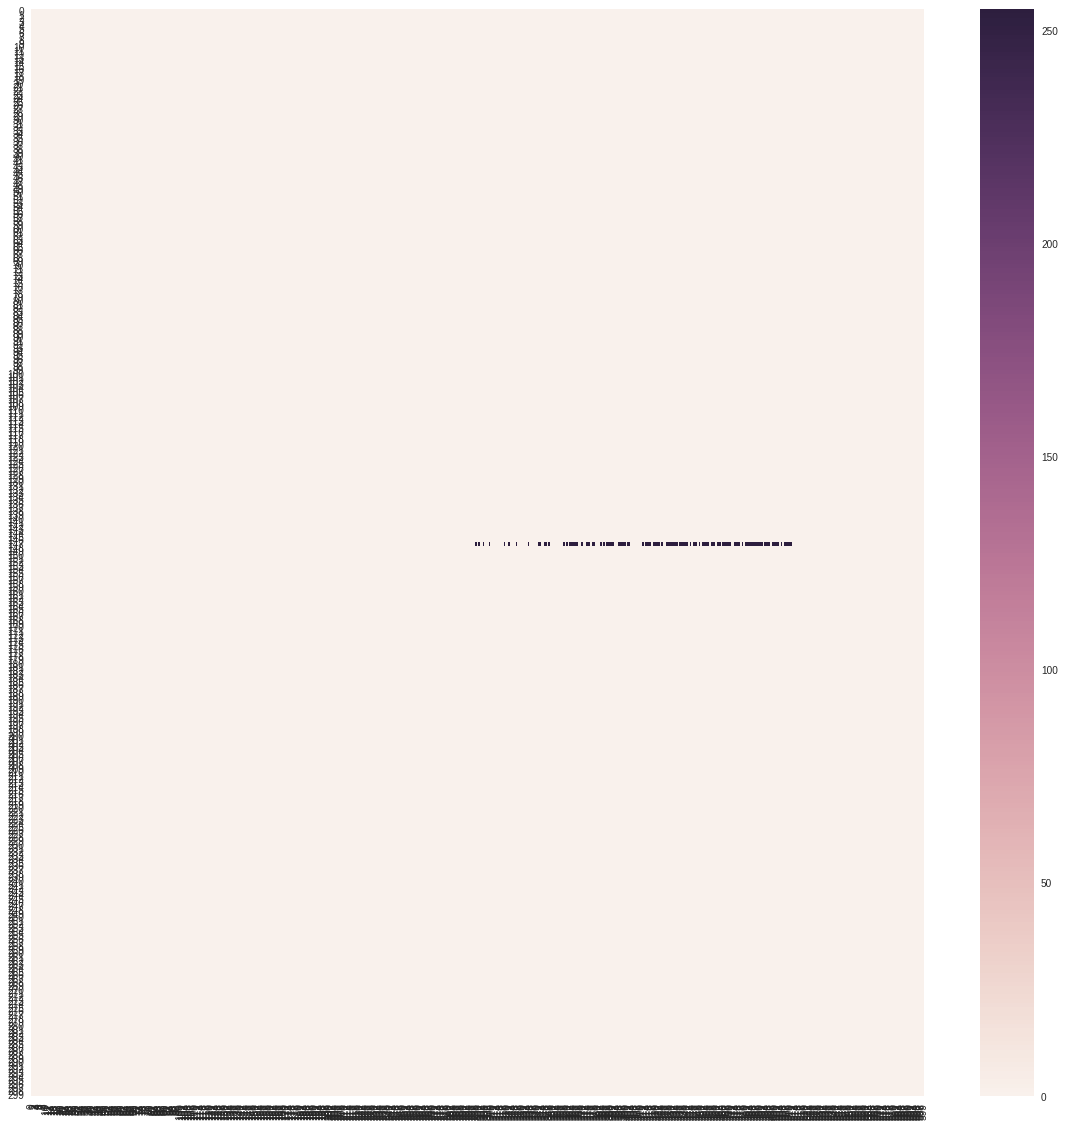

In [109]:
plt.figure(figsize=(20,20))
sns.heatmap(image1)

In [112]:
y,x= np.where(image1>20)

np.polyfit(x,y,1)

array([  9.56818296e-17,   1.47000000e+02])

In [113]:
def sigma(x,y):
    xc,yc = x.mean(), y.mean()
    x_,y_ = x-xc, y-yc
    r = np.sqrt(x_*x_+y_*y_)
    return np.std(r)
    

In [114]:
sigma(x,y)

30.224622422245599

In [130]:
image1[:150,:] = 0

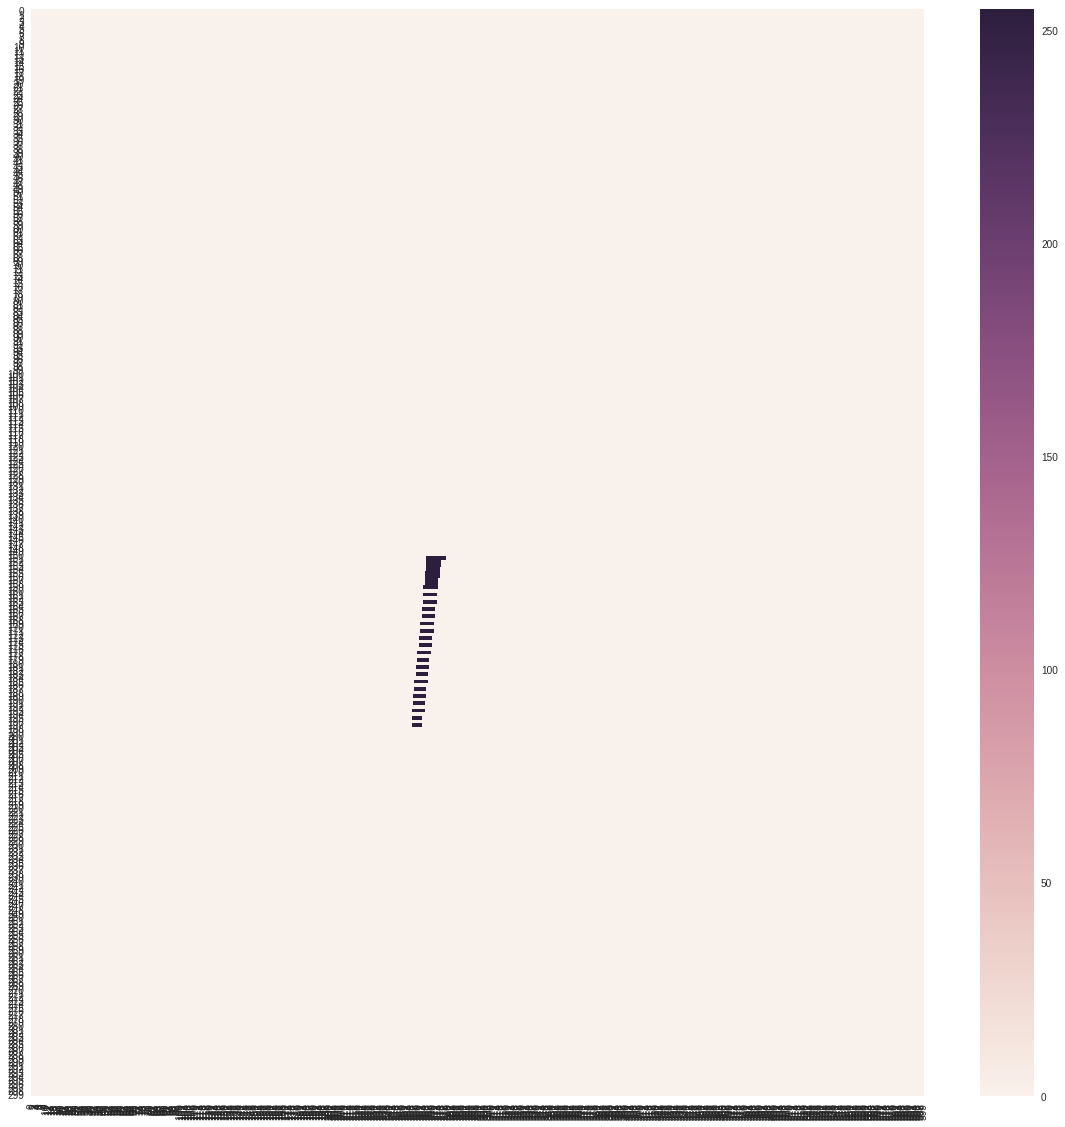

In [131]:
plt.figure(figsize=(20,20))
sns.heatmap(image1)

In [142]:
y,x= np.where(image1>20)
k3,b3 = np.polyfit(x,300-y,1)


In [143]:
print k3,b3


2.53095117938 -543.098522926


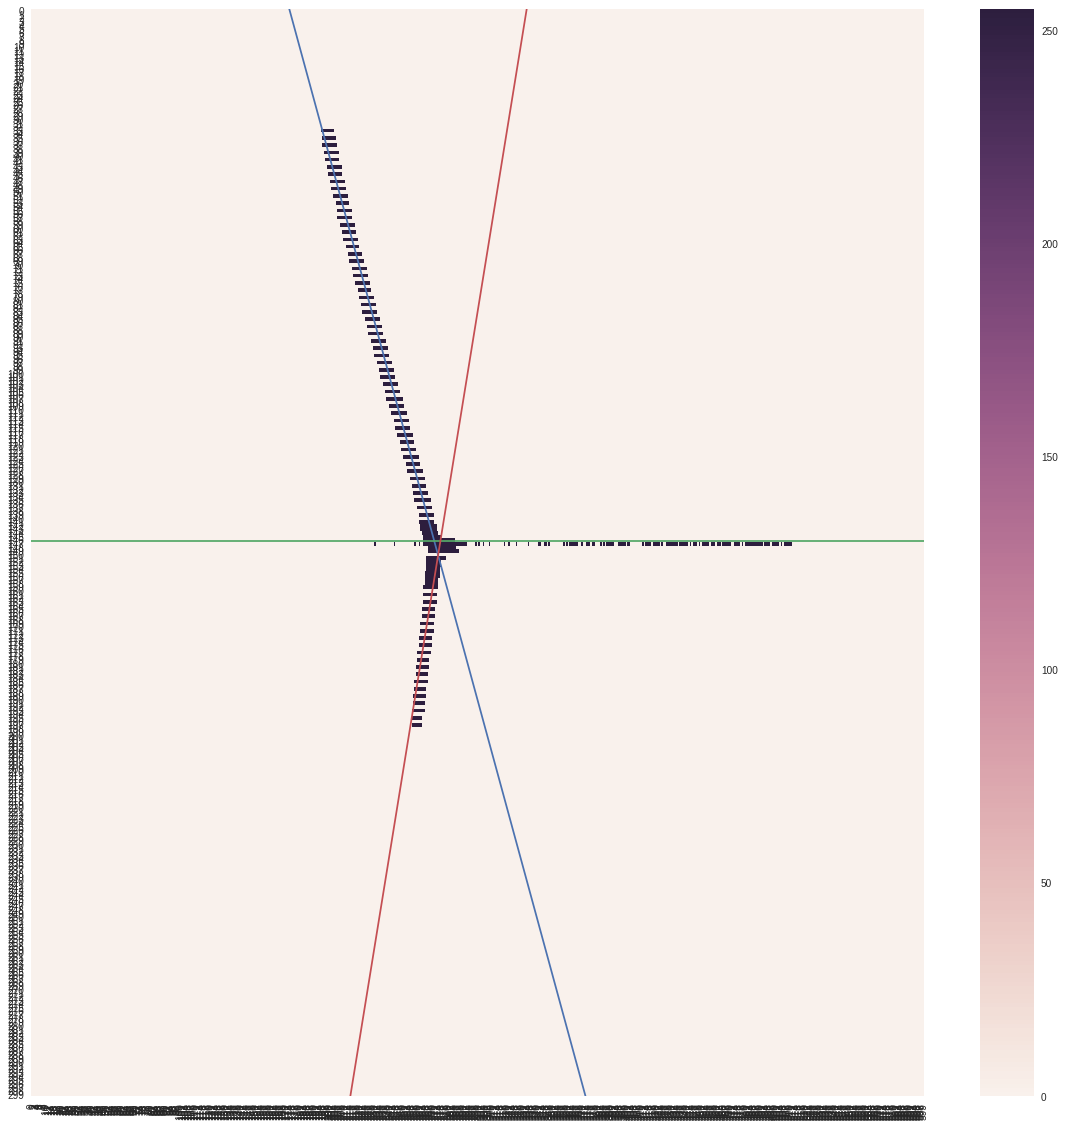

In [147]:
plt.figure(figsize=(20,20))
sns.heatmap(image1)

plt.plot([0,600],[561.4283658,-1.50696312*600+ 561.4283658 ])
plt.plot([0,600],[300-147,300-147])
plt.plot([0,600],[-543.098522926 ,2.53095117938*600 -543.098522926])
